In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import torch
import numpy as np
import normflows as nf
import matplotlib.pyplot as plt
#torch.autograd.set_detect_anomaly(True)

from birds.models.june import June
from birds.calibrator import Calibrator

In [3]:
device = "cuda:2"
config = yaml.safe_load(open("./june_config.yaml"))
config["system"]["device"] = device
config["data_path"] = "/cosma7/data/dp004/dc-quer1/gradabm_june_graphs/camden_leisure_1.pkl"
june = June(config, parameters_to_calibrate = ("beta_household", "beta_company", "beta_school"))

CPU times: user 210 ms, sys: 33.7 ms, total: 244 ms
Wall time: 258 ms


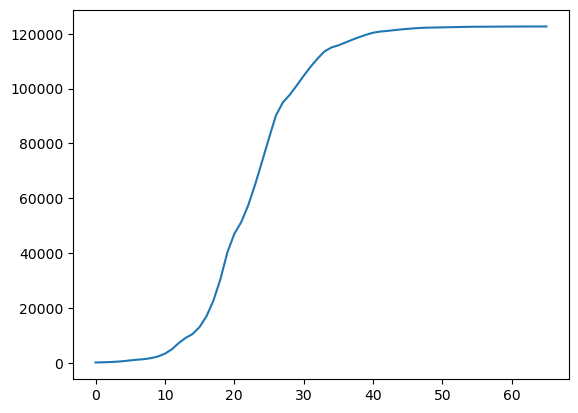

In [4]:
%%time
true_parameters = torch.tensor([0.9, 0.3, 0.6], device=device)
true_x = june.run(true_parameters)
true_data = june.observe(true_x)
plt.plot(true_data[0].cpu())

In [5]:
def make_flow():
    base = nf.distributions.base.DiagGaussian(len(true_parameters))
    num_layers = 5
    latent_size = len(true_parameters)
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([2, 50, 50, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    flow = nf.NormalizingFlow(base, flows)
    return flow.to(device)

In [6]:
torch.manual_seed(0)
prior = torch.distributions.MultivariateNormal(torch.tensor([0.5, 0.5, 0.5], device=device), 
                                               1.0 * torch.eye(len(true_parameters), device=device))
estimator = make_flow()
optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-3)
calibrator = Calibrator(model = june, 
                        posterior_estimator = estimator, 
                        prior=prior, 
                        data=true_data, 
                        optimizer=optimizer, 
                        n_samples_per_epoch=5,
                        w=0.001,
                        forecast_loss = torch.nn.MSELoss(),
                        log_tensorboard=True,
                        gradient_estimation_method="pathwise",
                        gradient_horizon=1,
                        #gradient_clipping_norm=1.0,
                       device=device)

calibrator.run(n_epochs=10000, max_epochs_without_improvement=50);

  1%| | 59/10000 [02:17<6:25:12,  2.32s/it, Forecast=5.06e+9, Reg.=0.000511, total=5.06e+9, b
